### Basics Imports

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/stackoverflow/stacksample'
# Using opendatasets let's download the data sets
od.download(dataset)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
questions_df = pd.read_csv('data/Questions.csv',encoding="ISO-8859-1")

In [3]:
print(f"Num or rows {questions_df.shape[0]}")
print(f"Num columns {questions_df.shape[1]} with columns {list(questions_df.columns)}")
questions_df.head()

Num or rows 1264216
Num columns 7 with columns ['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title', 'Body']


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [4]:
tags_df = pd.read_csv('data/Tags.csv',encoding="ISO-8859-1")

In [5]:
print(f"Num or rows {tags_df.shape[0]}")
print(f"Num columns {tags_df.shape[1]} with columns {list(tags_df.columns)}")
tags_df.head()

Num or rows 3750994
Num columns 2 with columns ['Id', 'Tag']


,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


## Some *Explorations*

<Axes: xlabel='Tag'>

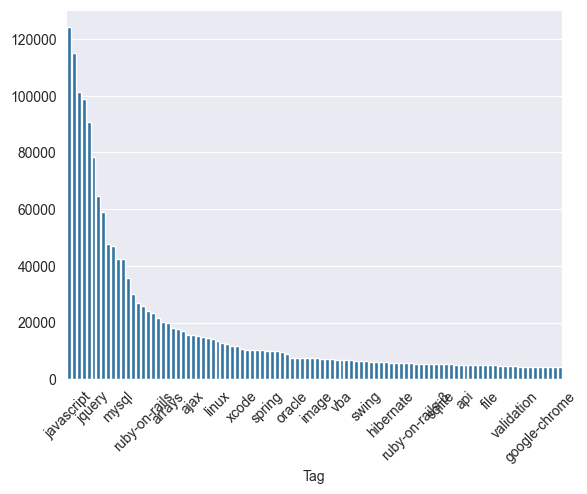

In [6]:
tag_value_counts = tags_df["Tag"].value_counts()
tag_value_counts = tag_value_counts.head(100)
tags_barplot = sns.barplot(x=tag_value_counts.index, y=tag_value_counts.values)
for i, label in enumerate(tags_barplot.xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
tags_barplot

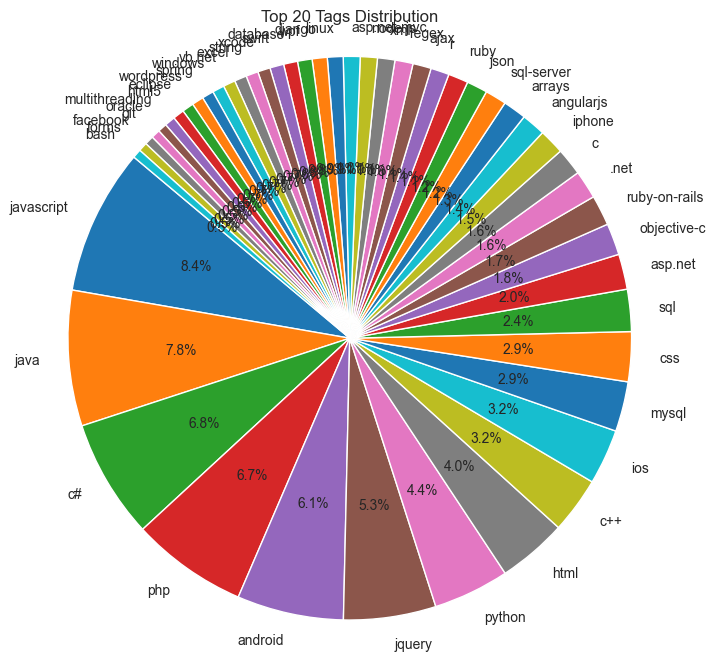

In [7]:
import matplotlib.pyplot as plt
tag_value_counts = tag_value_counts.head(50)

# Assuming you have top_tags as a pandas Series
plt.figure(figsize=(8, 8))
plt.pie(tag_value_counts , labels=tag_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Top 20 Tags Distribution')
plt.show()


### Reduce the number of tags due to memory allocation error


In [8]:
# standardize column names
for df in [questions_df, tags_df]:
    df.columns = df.columns.str.lower()
    
# group rows per question id
tags_df['tag'] = tags_df['tag'].astype(str)

tags_per_question_df = tags_df.groupby(['id'])['tag'].apply(lambda x: ' '.join(x))
df = questions_df[["id", "title", "body","score"]].merge(tags_per_question_df.to_frame(), on="id")
print(f" before scoring limitation: {df.shape}")
df = df[df['score']>5] # keep only positive scores due to memory allocation
print(f" after scoring limitation: {df.shape}")
df.head()


 before scoring limitation: (1264216, 5)
 after scoring limitation: (72950, 5)


,id,title,body,score,tag
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,26,flex actionscript-3 air
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,144,svn tortoisesvn branch branching-and-merging
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,21,sql asp.net sitemap
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,53,algorithm language-agnostic colors color-space
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,49,c# .net scripting compiler-construction


In [9]:

# Getting unique tags:
df['tag'] = df['tag'].apply(lambda x: x.split())
# All tags
all_tags = [item for sublist in df['tag'].values for item in sublist]
print(len(all_tags))

# Unique Tags
unique_tags = list(set(all_tags))
print(len(unique_tags))

224129
14883


In [10]:
import nltk
keywords = nltk.FreqDist(all_tags)
frequencies_words = keywords.most_common(15)
tags_features = [word[0] for word in frequencies_words]
print(len(tags_features))
tags_features

15


['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c']

In [11]:
# Function to filter most common tags
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered
# Apply filter and fill empty cells with none:
df['tag'] = df['tag'].apply(lambda x: most_common(x))
df['tag'] = df['tag'].apply(lambda x: x if len(x)>0 else None)
df.dropna(subset=['tag'], inplace=True)
df.shape

(44501, 5)

In [12]:
print(df["title"].str.len().min())
print(df["title"].str.len().max())

print(df["body"].str.len().min())
print(df["body"].str.len().max())
df.dtypes

9
170
25
30652


id        int64
title    object
body     object
score     int64
tag      object
dtype: object

Observing 189 char's for a title it's wrong! Probably the encoding is wrong!

In [13]:
df[df["title"].str.len() == df["title"].str.len().max()]

,id,title,body,score,tag
56755,2631820,I'm storing click coordinates in my db and the...,<p>That's it basically. Storing the click coor...,6,[javascript]


## Sanitizing Text!



*   Remove HTML tags
*   Remove Punctuation
*   Remove Stopwords
*   Lemmatize Text
*   Tokenize Text


In [14]:
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
!pip show lxml
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    return BeautifulSoup(text, "lxml").get_text()
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Tokenize text into words
    words = nltk.word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized_text



Name: lxml
Version: 5.1.0
Summary: Powerful and Pythonic XML processing library combining libxml2/libxslt with the ElementTree API.
Home-page: https://lxml.de/
Author: lxml dev team
Author-email: lxml-dev@lxml.de
License: BSD-3-Clause
Location: c:\users\yvariozidis\pycharmprojects\stack auto tagger\.venv\lib\site-packages
Requires: 
Required-by: 


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yvariozidis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
from tqdm import tqdm
tqdm.pandas()

df_clean = df
print('Removing Html Tags')
df_clean['body'] = df['body'].progress_apply(remove_html_tags)

print('Removing Punctuation')
df_clean['body'] = df['body'].progress_apply(remove_punctuation)
df_clean['title'] = df['title'].progress_apply(remove_punctuation)

print('Removing Stopwords')
df_clean['body'] = df['body'].progress_apply(remove_stopwords)
df_clean['title'] = df['title'].progress_apply(remove_stopwords)

print('Applying Lemmatization')
df_clean['body'] = df['body'].progress_apply(lemmatize_text)
df_clean['title'] = df['title'].progress_apply(lemmatize_text)

df_clean['title'] = df['title'].str.lower()
df_clean['body'] = df['body'].str.lower()

df_clean = df_clean.dropna(subset=['body','title','tag'])
df_clean.head()

Removing Html Tags


100%|██████████| 44501/44501 [00:25<00:00, 1734.09it/s]


Removing Punctuation


100%|██████████| 44501/44501 [00:00<00:00, 190430.38it/s]


Removing Stopwords


100%|██████████| 44501/44501 [00:05<00:00, 8705.74it/s] 


Applying Lemmatization


100%|██████████| 44501/44501 [00:04<00:00, 10176.70it/s]


,id,title,body,score,tag
4,260,adding scripting functionality net application,little game written c us database backend trad...,49,"[c#, .net]"
5,330,use nested class case,working collection class used video playback r...,29,[c++]
6,470,homegrown consumption web service,ive writing web service net app im ready consu...,13,[.net]
8,650,automatically update version number,would like version property application increm...,79,[c#]
10,930,connect database loop recordset c,whats simplest way connect query database set ...,28,[c#]


In [16]:
df_clean.to_csv("data/clean_data_filtered_15_score5.csv",index=False)

## Time for some tokenizing!

In [17]:
import nltk
def tokenize_text(text):
    tokens = tokenizer.tokenize(nltk.word_tokenize(text))
    return tokens

tokenizer = nltk.MWETokenizer(separator="")


df_clean['body_tokenized'] = df_clean['body'].progress_apply(tokenize_text)
df_clean['title_tokenized'] = df_clean['title'].progress_apply(tokenize_text)

df_clean.head(10)

df_clean.to_csv("data/clean_data_filtered_15_score5_tokenized.csv",index=False)

100%|██████████| 44501/44501 [00:03<00:00, 12871.81it/s]


## Time for some Feature Extraction!

**TF-IDF**

*   Term Frequency (TF): It measures how often a word appears in a document. If a word appears many times in a document, its TF value will be higher

*   Inverse Document Frequency (IDF): It measures how important a word is across documents. Words that appear frequently across many documents get a lower IDF score, while words that are rare or unique get a higher IDF score

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


clean_data_tokenized = pd.read_csv("data/clean_data_filtered_15_score5_tokenized.csv")

body_tfidf_vectorizer = TfidfVectorizer()
title_tfidf_vectorizer = TfidfVectorizer()
x_title = title_tfidf_vectorizer.fit_transform(clean_data_tokenized["title_tokenized"])
x_body = body_tfidf_vectorizer.fit_transform(clean_data_tokenized["body_tokenized"])
print(x_body,x_title)

  (0, 232087)	0.058337457420883164
  (0, 373010)	0.05099073060285736
  (0, 60488)	0.09260980630604417
  (0, 128245)	0.068521738309423
  (0, 196287)	0.12186293778490001
  (0, 97684)	0.14261970988498354
  (0, 68224)	0.14261970988498354
  (0, 225272)	0.14261970988498354
  (0, 232574)	0.03265625224036068
  (0, 68223)	0.14261970988498354
  (0, 124759)	0.051718550819249386
  (0, 180649)	0.08390675130455824
  (0, 131303)	0.03639206671098041
  (0, 279361)	0.07560717661426863
  (0, 264047)	0.08331518360614497
  (0, 166012)	0.08740315094559505
  (0, 258602)	0.06742298237825697
  (0, 330870)	0.08155666406090152
  (0, 306174)	0.048972797401287946
  (0, 124592)	0.07538885428687499
  (0, 107242)	0.08844758698353206
  (0, 50140)	0.21678716464205622
  (0, 231897)	0.09345489841356677
  (0, 371625)	0.04469369633496431
  (0, 278990)	0.07981970831022975
  :	:
  (44500, 66766)	0.02580800325857795
  (44500, 279864)	0.03851463166020671
  (44500, 121974)	0.032072346894605974
  (44500, 269454)	0.02848858804960

In [19]:
import pickle

# Save the TF-IDF matrix to a file
with open("fe_data/tfidf_title_filtered_15_score5.pkl", "wb") as f:
    pickle.dump(x_title, f)
with open("fe_data/tfidf_body_filtered_15_score5.pkl", "wb") as f:
    pickle.dump(x_body, f)    
    
# To be continue... check the next ipynb